# EfficientNetB0 Pretraining

LSTMに通す前に、まずCNNを事前学習させておく

１つの動画のデータサイズが大きくて一度に全ての動画がメインメモリに載り切らないため、
１つずつロードして学習や推論を行った

前処理として、動画の平均画像の差分をとり、さらに移動平均を引いたものを入力とした

前処理をmini-maxからnormalizeに変更した

scheduler.CosineAnnealingLRで学習率を変動させた

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Preprocessing

In [2]:
import tifffile
def load_image(filename):
    raw_image = tifffile.imread(filename)
    image1 = raw_image - raw_image.mean(axis=0)
    
    f_size=1000
    filter_ = np.ones(f_size)/f_size
    movemean = np.apply_along_axis(lambda m: np.convolve(m, filter_, mode='same'), axis=0, arr=image1) 
    image =  image1 - movemean
    
    ax = image.shape
    X_tmp = (image - image.mean()) / image.std() # Normalize
    #X_tmp = (image - image.min()) / (image.max() - image.min()) # MINI-MAX
    X = np.zeros([ax[0] - 2, 3, ax[1], ax[2]])
    X[:,0,:,:] = X_tmp[:-2, :, :]
    X[:,1,:,:] = X_tmp[1:-1, :, :]
    X[:,2,:,:] = X_tmp[2:, :, :]
    return X

In [3]:
FRAME_NUM = 18000 #動画のフレームの長さ
THR = 0.5 #runしているかどうかの判別の閾値

def load_label(filename):
    behave = pd.read_table(filename)
    Y = np.zeros([FRAME_NUM - 2, 1])
    for i in range(FRAME_NUM - 2):
        Speed = np.asarray(behave.Speed)
        idx = np.abs(np.asarray(behave.Frame) - (i+2)).argmin() # nearest value index
        Y[i,:] = Speed[idx] > THR
    print('positive proportion: {:.2}'.format(Y.sum() / FRAME_NUM))
    return Y

In [4]:
import glob
folder = 'data/'
data_tmp = glob.glob(folder + '*.tif')
data = []
for i in data_tmp:
    a = i.lstrip(folder).rstrip('.tif')
    data.append(a)

In [5]:
# 前半の半分をtraining、その後の1/4をvalidation、残りをinference
print(len(data))
train_len = len(data)//2
print(train_len)
valid_len = len(data)//2 + len(data)//4
print(valid_len)

43
21
31


In [6]:
# データ振り分け
train_data = data[:train_len]
print(train_data)
valid_data = data[train_len:valid_len]
print(valid_data)
infer_data = data[valid_len:]
print(infer_data)

['20180206_Emx1G6_non_1', '20180208_Emx1G6_non_1', '20180216_Emx1G6_R_1', '20180126_Emx1G6_LR_1', '20180207_Emx1G6_R_1', '20180201_Emx1G6_LR_1', '20180205_Emx1G6_R_1', '20180131_Emx1G6_R_1', '20180215_Emx1G6_LR_1', '20180131_Emx1G6_LR_1', '20180126_Emx1G6_R_1', '20180209_Emx1G6_R_1', '20180125_Emx1G6_non_1', '20180129_Emx1G6_non_1', '20180130_Emx1G6_R_1', '20180209_Emx1G6_LR_1', '20180214_Emx1G6_R_1', '20180215_Emx1G6_R_1', '20180130_Emx1G6_non_1', '20180208_Emx1G6_LR_1', '20180213_Emx1G6_R_1']
['20180207_Emx1G6_non_1', '20180130_Emx1G6_LR_1', '20180214_Emx1G6_non_1', '20180213_Emx1G6_LR_1', '20180207_Emx1G6_LR_1', '20180214_Emx1G6_LR_1', '20180216_Emx1G6_non_1', '20180206_Emx1G6_LR_1', '20180131_Emx1G6_non_1', '20180129_Emx1G6_R_1']
['20180216_Emx1G6_LR_1', '20180125_Emx1G6_R_1', '20180126_Emx1G6_non_1', '20180206_Emx1G6_R_1', '20180125_Emx1G6_LR_1', '20180213_Emx1G6_non_1', '20180208_Emx1G6_R_1', '20180209_Emx1G6_non_1', '20180129_Emx1G6_LR_1', '20180201_Emx1G6_non_1', '20180215_Emx1

In [7]:
import gc
def save_npz_train():
    for i in train_data:
        print(i)
        X = load_image(folder + i + '.tif')
        Y = load_label(folder + i +'.txt')
        for j in range(len(Y)):
            x = X[j,:,:,:]
            y = Y[j,:]
            np.savez(f'npz/train/{i}_{j}',x,y)
        del X, Y
        gc.collect();
        
def save_npz_valid():
    for i in valid_data:
        print(i)
        X = load_image(folder + i + '.tif')
        Y = load_label(folder + i +'.txt')
        for j in range(len(Y)):
            x = X[j,:,:,:]
            y = Y[j,:]
            np.savez(f'npz/valid/{i}_{j}',x,y)
        del X, Y
        gc.collect();

In [8]:
save_npz_train()

20180206_Emx1G6_non_1
positive proportion: 0.82
20180208_Emx1G6_non_1
positive proportion: 0.78
20180216_Emx1G6_R_1
positive proportion: 0.4
20180126_Emx1G6_LR_1
positive proportion: 0.37
20180207_Emx1G6_R_1
positive proportion: 0.53
20180201_Emx1G6_LR_1
positive proportion: 0.38
20180205_Emx1G6_R_1
positive proportion: 0.61
20180131_Emx1G6_R_1
positive proportion: 0.72
20180215_Emx1G6_LR_1
positive proportion: 0.046
20180131_Emx1G6_LR_1
positive proportion: 0.29
20180126_Emx1G6_R_1
positive proportion: 0.82
20180209_Emx1G6_R_1
positive proportion: 0.58
20180125_Emx1G6_non_1
positive proportion: 0.42
20180129_Emx1G6_non_1
positive proportion: 0.38
20180130_Emx1G6_R_1
positive proportion: 0.69
20180209_Emx1G6_LR_1
positive proportion: 0.21
20180214_Emx1G6_R_1
positive proportion: 0.41
20180215_Emx1G6_R_1
positive proportion: 0.45
20180130_Emx1G6_non_1
positive proportion: 0.84
20180208_Emx1G6_LR_1
positive proportion: 0.2
20180213_Emx1G6_R_1
positive proportion: 0.47


In [10]:
save_npz_valid()

20180207_Emx1G6_non_1
positive proportion: 0.81
20180130_Emx1G6_LR_1
positive proportion: 0.4
20180214_Emx1G6_non_1
positive proportion: 0.75
20180213_Emx1G6_LR_1
positive proportion: 0.27
20180207_Emx1G6_LR_1
positive proportion: 0.33
20180214_Emx1G6_LR_1
positive proportion: 0.14
20180216_Emx1G6_non_1
positive proportion: 0.34
20180206_Emx1G6_LR_1
positive proportion: 0.22
20180131_Emx1G6_non_1
positive proportion: 0.81
20180129_Emx1G6_R_1
positive proportion: 0.73


# Training

In [11]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [12]:
# seed固定
import os, random
SEED = 2020
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

In [13]:
BATCH_SIZE = 64
VER = 'b0'
from efficientnet_pytorch import EfficientNet
cnn = EfficientNet.from_pretrained('efficientnet-'+VER, num_classes=1)

Loaded pretrained weights for efficientnet-b0


In [14]:
model = cnn
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [15]:
# parameter数をカウント
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(params) 

4008829


In [16]:
from tqdm.auto import tqdm
class trainer:
    def __init__(self):
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.model = model
        self.lr = 1e-3
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr) 
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100, eta_min=self.lr * 0.1)
        
    def batch_train(self, batch_imgs, batch_labels, batch_idx):
        batch_imgs, batch_labels = batch_imgs.cuda().float(), batch_labels.cuda().float()
        predicted = self.model(batch_imgs)
        loss = self.loss_fn(predicted.float().reshape(-1), batch_labels.reshape(-1))
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item(), predicted
    
    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            loss, predicted = self.batch_train(imgs, labels, batch_idx)
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step()
        return current_loss_mean
    
    def valid_epoch(self, loader):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        current_accuracy_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                batch_imgs = imgs.cuda().float()
                batch_labels = labels.cuda().float()
                predicted = self.model(batch_imgs)
                loss = self.loss_fn(predicted.float().reshape(-1),batch_labels.float().reshape(-1)).item()
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
                output = (torch.sigmoid(predicted)>0.5).float()
                accuracy = (output == batch_labels).float().mean()
                current_accuracy_mean = (current_accuracy_mean * batch_idx + accuracy) / (batch_idx + 1)
                tqdm_loader.set_description('loss: {:.4} acc:{:.4}'.format(current_loss_mean, current_accuracy_mean))
        return current_loss_mean
        
    def predict(self, batch_imgs):
        self.model.eval()
        batch_imgs = batch_imgs.cuda().float()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
        return torch.sigmoid(predicted)

In [17]:
# training用のデータセットクラス
class ImageLoadDataset:
    def __init__(self, foldername):
        self.folder = glob.glob(foldername + '*.npz')
        
    def __len__(self):
        return (len(self.folder))
    
    def __getitem__(self, idx):
        xy_data = np.load(self.folder[idx])
        x = torch.tensor(xy_data['arr_0'], dtype=torch.float)
        y = torch.tensor(xy_data['arr_1'], dtype=torch.float)            
        return x, y

In [18]:
from torch.utils.data import DataLoader
Trainer = trainer()

def training():
    ds_t = ImageLoadDataset('npz/train/')
    train = DataLoader(ds_t, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=False)
    loss = Trainer.train_epoch(train)
    print('train loss {}'.format(loss))
    return loss

def validation():
    ds_v = ImageLoadDataset('npz/valid/')
    val = DataLoader(ds_v, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=False)
    loss = Trainer.valid_epoch(val)
    print('valid loss {}'.format(loss))
    return loss

In [19]:
# RUN
best_loss = np.inf
EPOCH = 2
score = np.zeros([EPOCH,2])
for i in range(EPOCH):
    print("----------Epoch {}-----------".format(i))
    score[i,0] = training()
    score[i,1] = validation()
    loss = score[i,1]
    if best_loss > loss:
        best_loss = loss
        torch.save(Trainer.model.state_dict(),"models/cnn_best_{}.pth".format(VER))
        print("save best model")

----------Epoch 0-----------



train loss 0.3019707935417232



valid loss 0.31188195255454904
save best model
----------Epoch 1-----------



train loss 0.2515184802438112



valid loss 0.3666337829836744


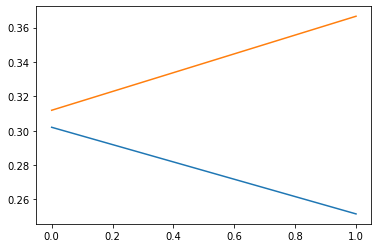

In [20]:
# plot result
plt.plot(score)

# Inference

In [21]:
Trainer.model.load_state_dict(torch.load("models/cnn_best_{}.pth".format(VER)))

<All keys matched successfully>

In [22]:
class ImageDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx, :, :, :], dtype=torch.float)
        y = torch.tensor(self.targets[idx, :], dtype=torch.float)            
        return x, y

In [23]:
def inference_1_image(filename):
    Y_pred = np.zeros([FRAME_NUM-2, 1])
    Y_true = np.zeros([FRAME_NUM-2, 1])
    X = load_image(folder + filename + '.tif')
    Y = load_label(folder + filename +'.txt')
    ds_i = ImageDataset(X, Y)
    infe = DataLoader(ds_i, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=False)
    tqdm_loader = tqdm(infe)
    for idx, (imgs,labels) in enumerate(tqdm_loader):
        bs = labels.shape[0]
        Y_pred[idx*bs:(idx+1)*bs] = Trainer.predict(imgs).cpu()
        Y_true[idx*bs:(idx+1)*bs] = labels
    del X, Y, ds_i, infe, tqdm_loader
    gc.collect();
    return Y_pred, Y_true

In [24]:
def calculate_accuracy():
    acc = np.zeros(len(infer_data))
    for i, file in enumerate(infer_data):
        print(file)
        Y_pred, Y_true = inference_1_image(file)
        output = Y_pred > 0.5
        accuracy = (output == Y_true).mean()
        print('Accuracy:{}'.format(accuracy))
        acc[i] = accuracy
    print('Mean Accuracy:{}'.format(acc.mean()))

In [25]:
calculate_accuracy()

20180216_Emx1G6_LR_1
positive proportion: 0.035



Accuracy:0.9426602955883987
20180125_Emx1G6_R_1
positive proportion: 0.76



Accuracy:0.9377153017001889
20180126_Emx1G6_non_1
positive proportion: 0.26



Accuracy:0.8914323813757085
20180206_Emx1G6_R_1
positive proportion: 0.61



Accuracy:0.9089898877653072
20180125_Emx1G6_LR_1
positive proportion: 0.34



Accuracy:0.8695410601177909
20180213_Emx1G6_non_1
positive proportion: 0.83



Accuracy:0.8675963995999556
20180208_Emx1G6_R_1
positive proportion: 0.38



Accuracy:0.8923213690410046
20180209_Emx1G6_non_1
positive proportion: 0.71



Accuracy:0.9126014001555729
20180129_Emx1G6_LR_1
positive proportion: 0.32



Accuracy:0.8681520168907656
20180201_Emx1G6_non_1
positive proportion: 0.75



Accuracy:0.8820980108900989
20180215_Emx1G6_non_1
positive proportion: 0.45



Accuracy:0.8995443938215357
20180201_Emx1G6_R_1
positive proportion: 0.7



Accuracy:0.8628736526280698
Mean Accuracy:0.8946271807978664


In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

def inference():
    Y_pred_all = np.zeros([(FRAME_NUM-2)*len(infer_data), 1])
    Y_true_all = np.zeros([(FRAME_NUM-2)*len(infer_data), 1])
    for i, file in enumerate(infer_data):
        print(file)
        Y_pred, Y_true = inference_1_image(file)
        Y_pred_all[i*(FRAME_NUM-2):(i+1)*(FRAME_NUM-2), 0] = Y_pred[:,0]
        Y_true_all[i*(FRAME_NUM-2):(i+1)*(FRAME_NUM-2), 0] = Y_true[:,0]
        plt.plot(Y_true, label="grand truth")
        plt.plot(Y_pred, label="prediction")
        plt.legend()
        plt.show()
        fpr, tpr, thresholds = roc_curve(Y_true, Y_pred, pos_label=1)
        AUC = roc_auc_score(Y_true, Y_pred)
        plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
        plt.title("ROC curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()
        print('AUCは')
        print(auc(fpr, tpr))
        print('です。')
        print('最適な閾値は')
        opt_thr = thresholds[np.argmax(tpr - fpr)]
        print(opt_thr)
        print('です。')
        plt.plot(Y_true, label="grand truth")
        plt.plot(Y_pred > opt_thr, label="prediction")
        plt.title("Optimal threshold")
        plt.legend()
        plt.show()
        del Y_pred, Y_true
        gc.collect();
    return Y_pred_all, Y_true_all

20180216_Emx1G6_LR_1
positive proportion: 0.035


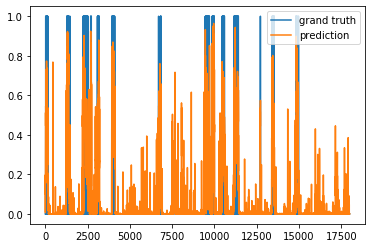

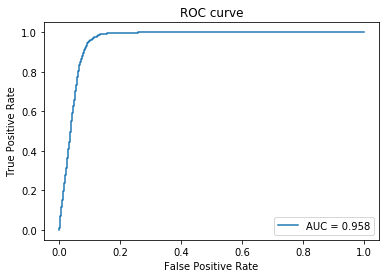

AUCは
0.9584447583037431
です。
最適な閾値は
0.1799495816230774
です。


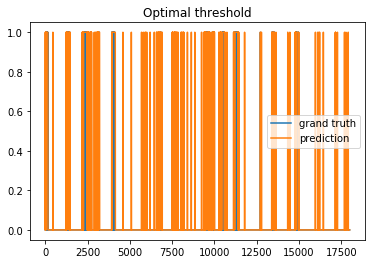

20180125_Emx1G6_R_1
positive proportion: 0.76


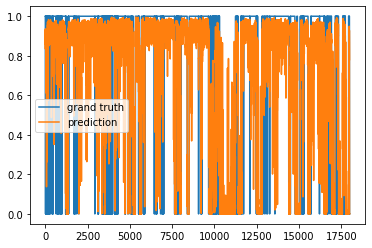

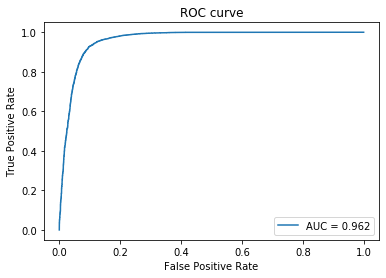

AUCは
0.9615172970007383
です。
最適な閾値は
0.7379025816917419
です。


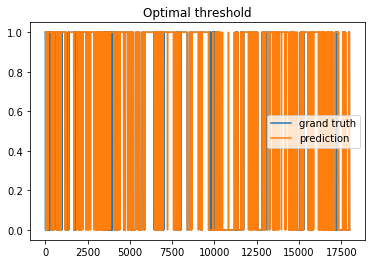

20180126_Emx1G6_non_1
positive proportion: 0.26


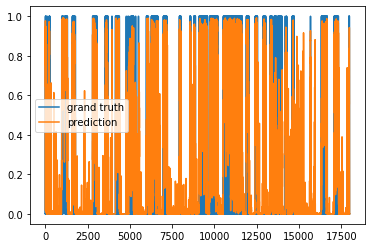

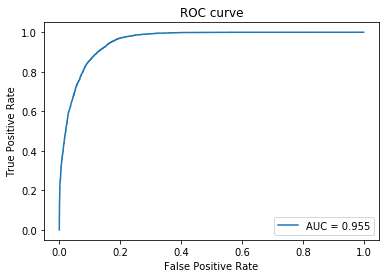

AUCは
0.9550880478627953
です。
最適な閾値は
0.1573888212442398
です。


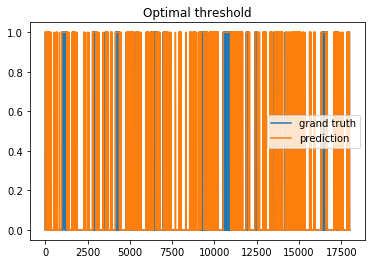

20180206_Emx1G6_R_1
positive proportion: 0.61


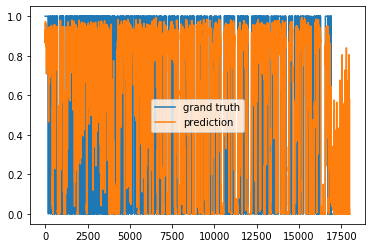

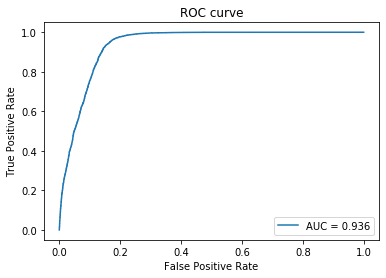

AUCは
0.9360287229909275
です。
最適な閾値は
0.5128875970840454
です。


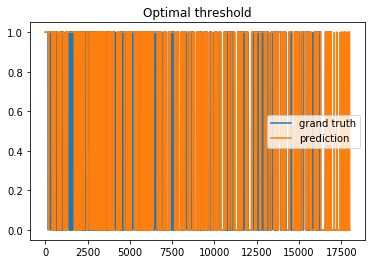

20180125_Emx1G6_LR_1
positive proportion: 0.34


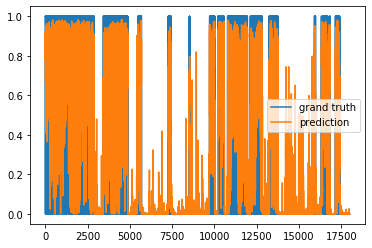

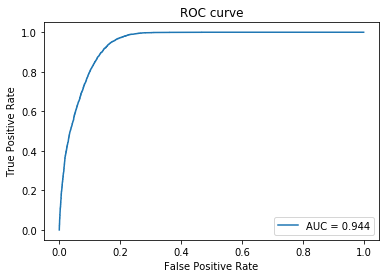

AUCは
0.9436981267380588
です。
最適な閾値は
0.22857187688350677
です。


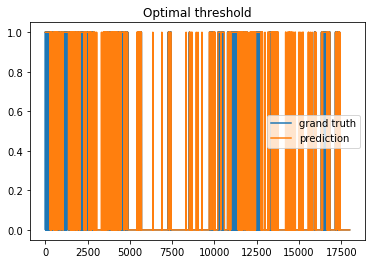

20180213_Emx1G6_non_1
positive proportion: 0.83


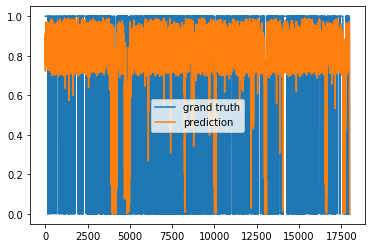

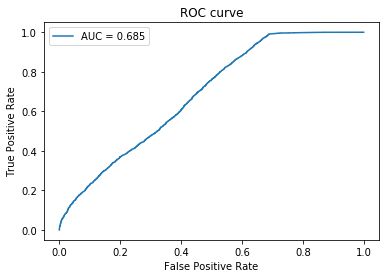

AUCは
0.6847045071108662
です。
最適な閾値は
0.6994704604148865
です。


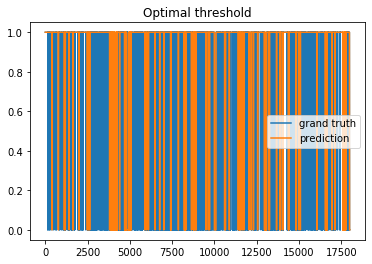

20180208_Emx1G6_R_1
positive proportion: 0.38


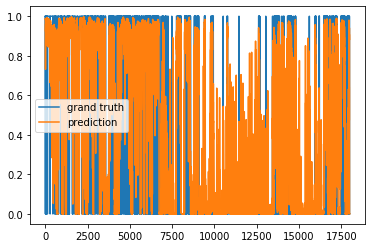

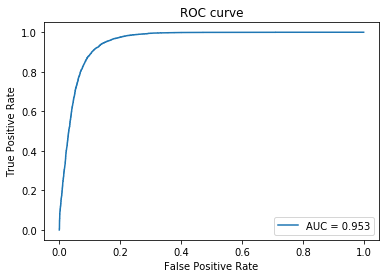

AUCは
0.9530424440060431
です。
最適な閾値は
0.47847235202789307
です。


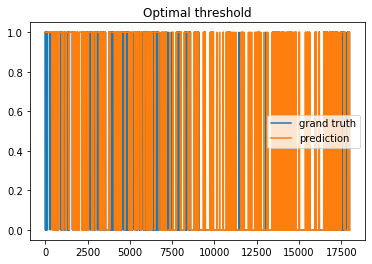

20180209_Emx1G6_non_1
positive proportion: 0.71


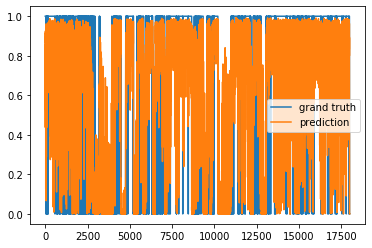

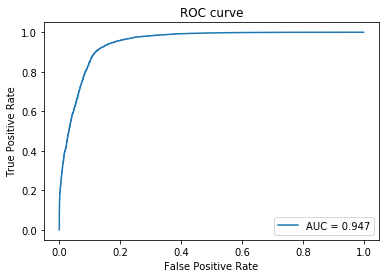

AUCは
0.9465290368897165
です。
最適な閾値は
0.6593587398529053
です。


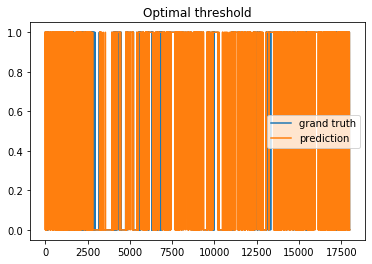

20180129_Emx1G6_LR_1
positive proportion: 0.32


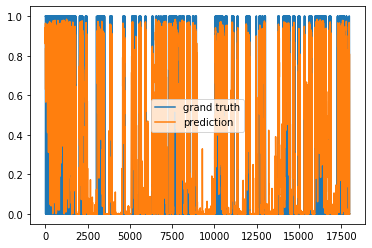

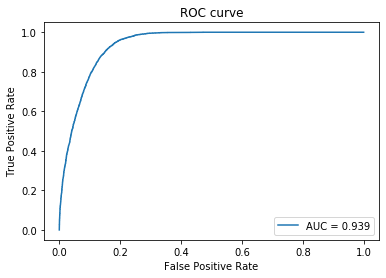

AUCは
0.938667621175075
です。
最適な閾値は
0.2905762791633606
です。


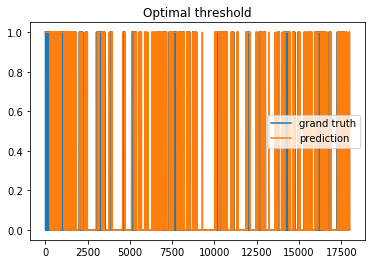

20180201_Emx1G6_non_1
positive proportion: 0.75


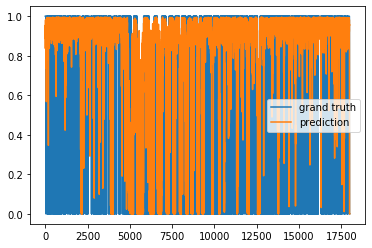

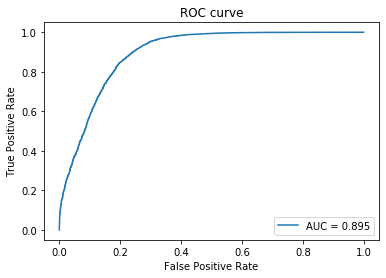

AUCは
0.8946888127504071
です。
最適な閾値は
0.8754432797431946
です。


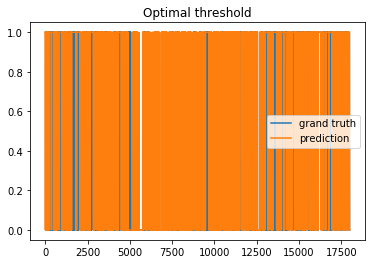

20180215_Emx1G6_non_1
positive proportion: 0.45


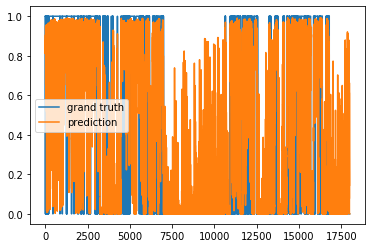

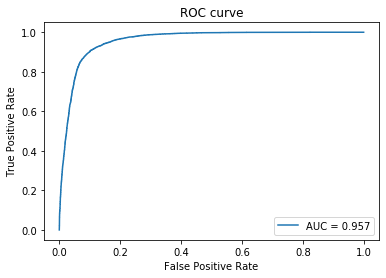

AUCは
0.9573464725102275
です。
最適な閾値は
0.5511122941970825
です。


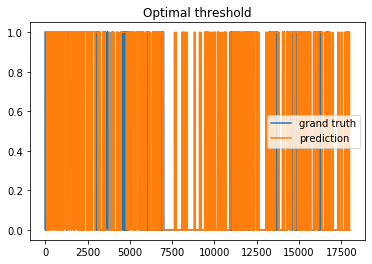

20180201_Emx1G6_R_1
positive proportion: 0.7


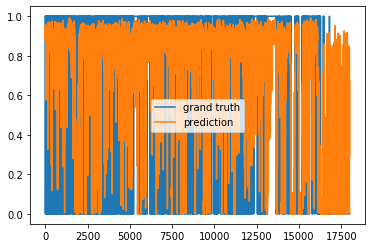

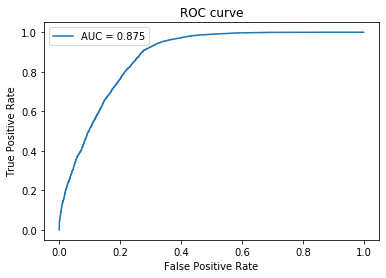

AUCは
0.8747715802079152
です。
最適な閾値は
0.7788852453231812
です。


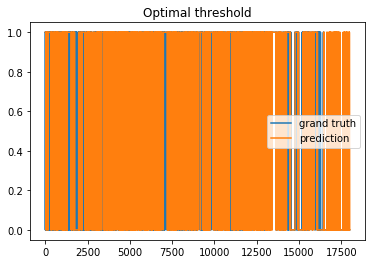

In [35]:
Y_pred, Y_true = inference()

In [36]:
output = Y_pred > 0.5
accuracy = (output == Y_true).mean()
print('Accuracy:{}'.format(accuracy))

Accuracy:0.8946271807978664


/home/takehiro/anaconda3/envs/kaggle/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


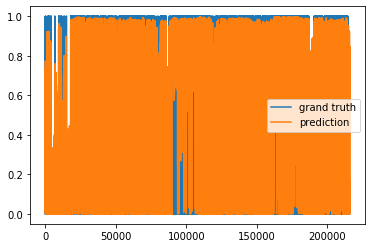

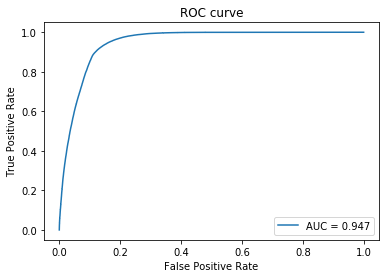

AUCは
0.946792442610606
です。
最適な閾値は
0.556788980960846
です。


/home/takehiro/anaconda3/envs/kaggle/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


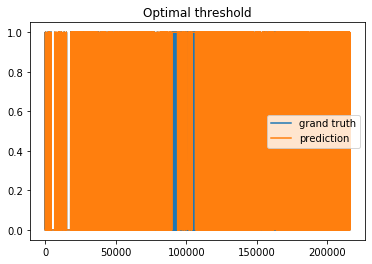

In [37]:
plt.plot(Y_true, label="grand truth")
plt.plot(Y_pred, label="prediction")
plt.legend()
plt.show()
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred, pos_label=1)
AUC = roc_auc_score(Y_true, Y_pred)
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print('AUCは')
print(auc(fpr, tpr))
print('です。')
print('最適な閾値は')
opt_thr = thresholds[np.argmax(tpr - fpr)]
print(opt_thr)
print('です。')
plt.plot(Y_true, label="grand truth")
plt.plot(Y_pred > opt_thr, label="prediction")
plt.title("Optimal threshold")
plt.legend()
plt.show()